# 🛡️ Elderly People Support Based on AI Agents
Author: Eduardo Seiti Ito

Track: Agents for Good

Goal: A multi-agent system for elderly care support.

Course: 5-Day AI Intensive Course with Google/Kaggle

### 🤔 The Problem

Many elderly individuals wish to live independently but face significant challenges in managing the complex logistics of modern life. This includes remembering medications, scheduling doctor appointments, coordinating proper nutrition, and combating social isolation. Furthermore, a reactive system isn't enough; families need peace of mind that proactive monitoring is in place to handle unexpected health events, which are often full of uncertainty.

### ✅ The Solution: The Multi-Agent AI System for Elderly People Living Assistance

Herein is proposed a proactive multi-agent AI system for elderly people that operates in two parts:

- ✨ **Conversational Assistant** - A friendly "Guardian" orchestrator agent that understands a senior's natural language requests (e.g., "I'm hungry," "When is my doctor's visit?") and delegates tasks to a team of specialists (HealthMinder, NutritionPal, JoyConnect). For this purpose, Gemini 2.5 Flash Lite has allocated for routing.

- ✨ **Proactive Monitor** - A "ProactiveHealth" loop agent that runs 24/7, simulating sensor data (like blood pressure). When it detects an anomaly, it uses a RAG-based tool to semantically query a health protocol database, understand the uncertainty, and decide on the safest course of action—from a simple "drink water" alert to "call family.". Here is where is used the concept of Model-Controller-Program (MCP) in a Agent Loop.

This project intends to demonstrate a robust, personalized system that moves beyond simple task-completion to provide a true safety and support net.

### 🏗️ Multi-Agent AI System Architecture for Elderly Support

The Multi-Agent AI System architecture is displayed below:

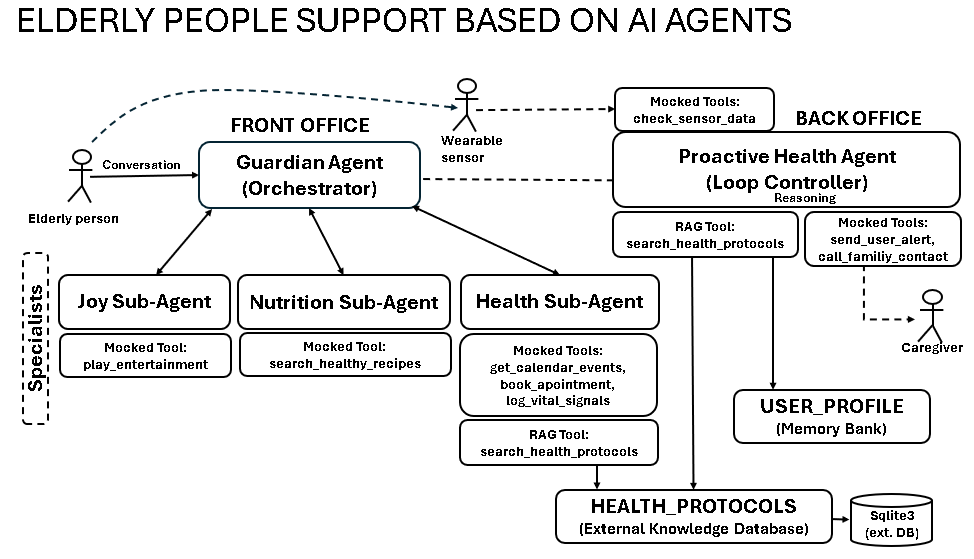

And, the following concepts are introduced.

1. **Multi-Agent AI System**: The architecture cleanly separates concerns between a Guardian orchestrator (for user-facing tasks) and a ProactiveHealth agent (for background monitoring), which talk to specialists.

2. **Tools**: The system uses a wide array of the following tools: set_medication_reminder, check_sensor_data, send_user_alert.

   **Custom tools**: set_medication_reminder, check_sensor_data, send_user_alert.

   **OpenAPI-style**: Calendar mock for simulation of API call (e.g. Google Calendar could be used in production).

   **RAG Tool**: The search_health_protocols tool is a perfect example of providing context for an LLM to "semantically search" and reason over. Here is where external database (sqlite backend) contains health protocol data is used for health search tool.

3. **Loop Agents (and MCP)**: The ProactiveHealth agent is a loop agent that runs 24/7. It uses the Model-Controller-Program pattern to handle complex, uncertain health data, moving from sensor reading -> to protocol retrieval -> to reasoned action.

### 🎯 Value Proposition
The Guardian System solves the problem of information overload by serving as a central intelligence layer. It ensures **safety** (via immediate vital sign protocols) and **personalization** (via direct access to user preferences and schedules).

### 🛠️ Technology Stack
| Component | Function | Status |
| :--- | :--- | :--- |
| **Framework** | Google ADK (Agent Development Kit) | Core Architecture |
| **LLM** | Gemini 2.5 Flash for {Orchestrator} and {Specialists} | Reasoning Engine |
| **Architecture** | Hierarchical Delegation (Orchestrator -> Sub-Agents) | Final Design |
| **Execution Pattern** | Local Sub-Agents (In-Process) | Stable Solution |
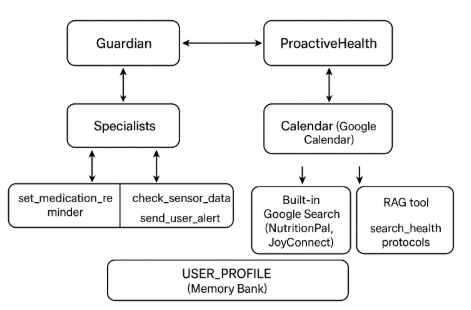
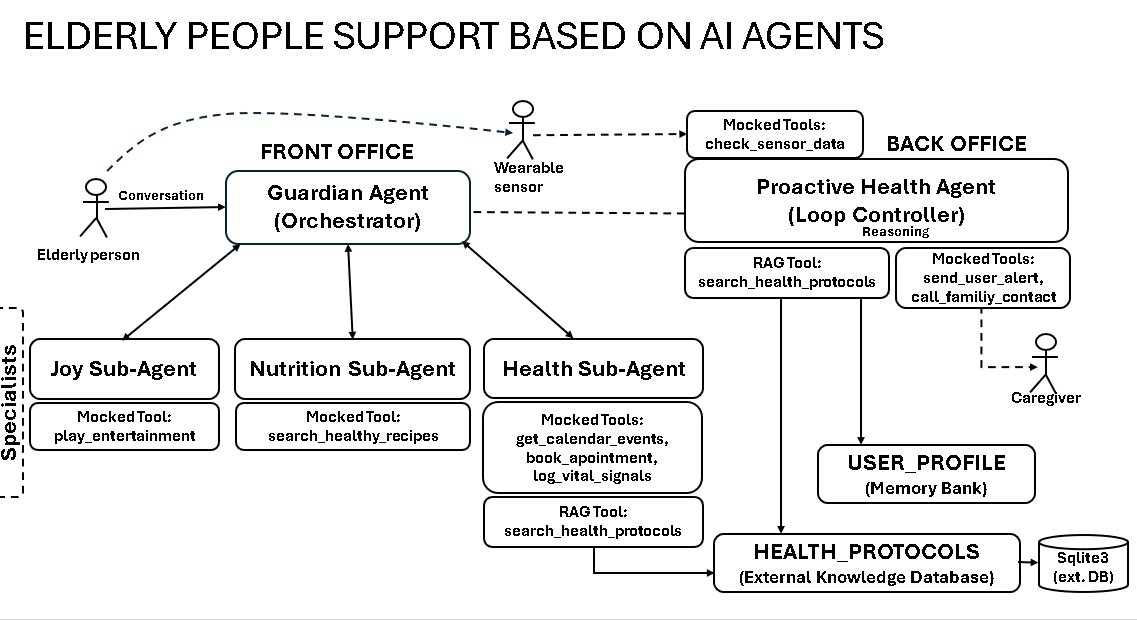

## 1. ⚙️ Setup & Dependencies

In [1]:
# --- Environment Setup (Handle API Keys) ---
# Use Kaggle Secrets to store API keys
# from kaggle_secrets import UserSecretsClient
# secrets = UserSecretsClient()

import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ GOOGLE_API_KEY setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

# NOTE: For this Capstone simulation, we use mock calendar data. 
# In a production environment, this token would authenticate with the Google Calendar API.
#try:
#    CALENDAR_TOKEN = UserSecretsClient().get_secret("CALENDAR_TOKEN")
#    os.environ["CALENDAR_TOKEN"] = CALENDAR_TOKEN
#    print("✅ CALENDAR_TOKEN setup and authentication complete.")
#except Exception as e:
#    print(
#        f"🔑 Authentication Error: Please make sure you have added 'CALENDAR_TOKEN' to your Kaggle secrets. Details: {e}"
#    )

✅ GOOGLE_API_KEY setup and authentication complete.


In [2]:
import json
import uuid
import warnings
import asyncio
import nest_asyncio
import logging
from datetime import datetime
import random
import sqlite3
import re

# --- Core ADK Components ---
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

# --- Google Gemini Components ---
from google.genai import types

# --- Configuration ---
# 1. Apply async patch for Jupyter
nest_asyncio.apply()

# 2. Suppress noisy warnings (Function calling logs)
warnings.filterwarnings('ignore')
logging.getLogger("google_genai.types").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR) 
logging.getLogger("aiohttp").setLevel(logging.ERROR)

print("All ADK and Google GenAI libraries imported correctly.")

All ADK and Google GenAI libraries imported correctly.


### Configure Retry Options

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [4]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

print("Retry option configured!")

Retry option configured!


## 2. 🧠 Core Memory & Knowledge Base
This is the static data our agents will use for personalization and reasoning.

In [5]:
import random
import datetime

# --- Key Concept 1: Long-Term Memory (The "User Profile") ---
# This dictionary represents our "Memory Bank" for personalization.
USER_PROFILE = {
    "name": "Margaret",
    "baseline_bp": "120/80",
    "dietary_restrictions": ["low-sodium", "allergic to peanuts"],
    "primary_doctor": "Dr. Evans (555-1234)",
    "family_contact": {
        "name": "David (Son)",
        "phone": "555-9876"
    },
    "preferences": {
        "music": "classical, 1940s big band",
        "hobbies": "audiobooks, gardening"
    },
    "calendar_id": "primary" # The user's Google Calendar ID
}


# --- Knowledge Base for Proactive Agent (RAG) ---
# This is the "database" our RAG tool will provide to the LLM.

# Note: This code assumes DB_NAME is defined as "health_protocols.db"

DB_NAME = "health_protocols.db"

def initialize_protocols_db():
    """
    Creates the SQLite database with granular columns, fully synchronizing 
    with all severity levels defined in the original HEALTH_PROTOCOLS.
    """
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()
    
    # 1. Create table (Structure remains the same)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS protocols (
            id INTEGER PRIMARY KEY,
            vitals_type TEXT,
            severity TEXT,
            min_systolic INTEGER,
            min_diastolic INTEGER,
            protocol_text TEXT
        )
    """)
    
    # 2. Insert comprehensive data (Synchronized to all three severity levels)
    protocols_data = [
        # --- Protocol 2: High Blood Pressure (Hypertension) ---
        # Type, Severity, Min_Sys, Min_Dia, Text
        ('high_bp', 'Mild', 140, 90, "Action (Mild): Instruct user to rest for 5 minutes and re-check. Remind them to take medication if missed."),
        ('high_bp', 'Urgent', 160, 100, "Action (Urgent): Instruct to rest and take missed medication. Re-check in 1 hour. If still high, advise calling doctor."),
        ('high_bp', 'Crisis', 180, 120, "Action (Crisis): Advise calling doctor or emergency services immediately."),
        
        # --- Protocol 1: Low Blood Pressure (Hypotension) ---
        # NOTE: We use simplified numeric triggers here (0/0) and rely on the LLM 
        # to reason over the specific numbers (90/60, 90/50) provided in the text.
        
        # Action (Mild) - BP > 90/60 but low relative to baseline
        ('low_bp', 'Mild', 90, 60, "Action (Mild): If BP is > 90/60 but low, instruct user to sit down, drink a full glass of water, and eat a small salty snack."),
        
        # Action (Moderate) - BP is < 90/60 OR user reports dizziness
        # We set the trigger to the lower bound (90/60) and rely on the text for complexity.
        ('low_bp', 'Moderate', 0, 0, "Action (Moderate): If BP is < 90/60 OR user reports dizziness, instruct to lie down with feet elevated. Re-check BP in 15 minutes."),
        
        # Action (Severe) - BP < 90/50 OR non-responsive
        ('low_bp', 'Severe', 0, 0, "Action (Severe): If BP is < 90/50 OR user is non-responsive, call family contact immediately."),

        # --- Protocol 3: Low Heart Rate (Bradycardia) ---
        ('low_hr', 'Action', 0, 0, "Action: If HR is < 60 bpm, instruct user to sit down. If HR is < 50 and they feel dizzy, call family contact."),
    ]
    
    cursor.execute("DELETE FROM protocols")
    cursor.executemany("INSERT INTO protocols (vitals_type, severity, min_systolic, min_diastolic, protocol_text) VALUES (?, ?, ?, ?, ?)", protocols_data)
    
    conn.commit()
    conn.close()
    
    print(f"✅ Protocol Database '{DB_NAME}' synchronized and populated with {len(protocols_data)} detailed records.")

# Initialize the database immediately (This needs to run once)
initialize_protocols_db()

print("Core Memory and Knowledge Base loaded.")

✅ Protocol Database 'health_protocols.db' synchronized and populated with 7 detailed records.
Core Memory and Knowledge Base loaded.


## 3. 🛠️ Key Concept 2: Tool Definitions
We'll define two sets of tools: one for the conversational agents and one for the proactive agent

In [6]:
# --- TOOL DEFINITIONS ---

def get_calendar_events(day: str):
    """Retrieves the user's schedule for a specific day."""
    # Mock logic
    if day.lower() in ["today", "tuesday"]:
        return "10:00 AM: Physiotherapy\n02:00 PM: Tea with Mrs. Higgins"
    return "No events scheduled."

def book_appointment(doctor_name: str, date_time: str):
    """Books a medical appointment."""
    return f"✅ CONFIRMED: Appointment with {doctor_name} set for {date_time}."

def search_healthy_recipes(ingredients: str):
    """Finds recipes that match the user's low-sodium diet."""
    return f"🥗 RECIPE FOUND: Low-sodium Roasted {ingredients} with herbs."

def play_entertainment(mood: str):
    """Plays music or audiobooks based on mood."""
    if "relax" in mood.lower():
        return "🎵 NOW PLAYING: 'Moonlight Serenade' by Glenn Miller"
    return "🎵 NOW PLAYING: 'In the Mood' by Glenn Miller"

def log_vital_signs(systolic: int, diastolic: int):
    """Logs blood pressure readings."""
    status = "Normal"
    if systolic > 140: 
        status = "ELEVATED - Alerting Family"
    return f"💗 VITALS LOGGED: {systolic}/{diastolic} ({status})"

# --- 1. Tool Functions (Program) ---
def check_sensor_data(sensor_type: str) -> str:
    """Checks the latest data from a health sensor (e.g., 'blood_pressure', 'heart_rate')."""
    if random.random() < 0.8:
        return "Anomaly Detected: Blood Pressure is 165/105. Heart Rate is 85 bpm."
    return "Vitals are stable: 120/80 BP, 70 bpm HR."

def send_user_alert(alert_message: str) -> str:
    """Sends a critical alert directly to the user's connected device."""
    return f"🚨 ALERT SENT TO USER: {alert_message}"

def call_family_contact(reason: str) -> str:
    """Calls the family's emergency contact due to a critical situation."""
    return f"📞 FAMILY CONTACTED: Notifying about urgent event: {reason}"

# --- PROACTIVE TOOLS ---

def check_sensor_data(sensor_type: str) -> str:
    """Checks the latest data from a health sensor (e.g., 'blood_pressure', 'heart_rate')."""
    # Simulate an anomaly 80% of the time for demonstration
    if random.random() < 0.8:
        # High BP anomaly: 165/105
        return "Anomaly Detected: Blood Pressure is 165/105. Heart Rate is 85 bpm."
    else:
        return "Vitals are stable: 120/80 BP, 70 bpm HR."

#def search_health_protocols(vitals_data: str) -> str:
#    """Searches the knowledge base for relevant health protocols based on current vitals."""
#    # Since we injected HEALTH_PROTOCOLS, we can simulate the RAG retrieval here.
#    if "165/105" in vitals_data:
#        return f"Protocol Found: [Protocol 2: High Blood Pressure (Hypertension)] - Action (Urgent): If BP is > 160/100, instruct rest, check for missed medication, and advise calling doctor."
#    return "Protocol Found: [Protocol 1: Low Blood Pressure (Hypotension)] - Instruction: Sit down, drink water."

# --- RAG-Enabled Tool Definition ---

def search_health_protocols(vitals_data: str) -> str:
    """
    Performs a multi-layered RAG search against the SQLite database.
    It extracts vitals and retrieves ALL relevant protocols (Mild, Urgent, Crisis)
    to enable comprehensive reasoning by the LLM (MCP Model).
    """
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()
    
    # Use RegEx to reliably extract all numbers that look like BP readings
    numbers = [int(n) for n in re.findall(r'\b\d{2,3}\b', vitals_data)]
    
    if len(numbers) < 2:
        conn.close()
        return "Protocol Found (Error): Vitals data was unreadable. Advise user to check sensor."

    # Assume the first two numbers are Systolic and Diastolic
    systolic, diastolic = numbers[0], numbers[1]

    # 1. Determine the relevant Vitals Type (Simplification for RAG query)
    vitals_type = 'unknown'
    if systolic >= 140 or diastolic >= 90:
        vitals_type = 'high_bp'
    elif systolic < 100 and diastolic < 70:
        vitals_type = 'low_bp'
            
    # 2. Execute SQL search for ALL matching protocols
    # This query retrieves all severity levels where the current reading meets the minimum criteria.
    cursor.execute("""
        SELECT severity, protocol_text 
        FROM protocols 
        WHERE vitals_type = ? 
        AND min_systolic <= ? 
        ORDER BY min_systolic DESC
    """, (vitals_type, systolic))
    
    results = cursor.fetchall()
    conn.close()
    
    if not results:
        return "Protocol Found (Normal): Vitals are within normal limits, advise continued monitoring."
    
    # 3. Format the comprehensive RAG result for the LLM
    protocol_output = "--- RETRIEVED PROTOCOLS ---\n"
    for severity, text in results:
        protocol_output += f"[{severity}]: {text}\n"
    
    return protocol_output

print("✅ Tools Defined.")

✅ Tools Defined.


## 4. 🤖 The Agents (Specialists & Orchestrator)

The Orchestrator (the "Guardian") to route tasks to specialists. This demonstrates Context Engineering by passing relevant USER_PROFILE data

In [13]:
# --- Model Definitions ---
# We create a separate Gemini model object for each agent,
# embedding the system prompt directly into the model.

specialist_model = Gemini(
    model="gemini-2.5-flash-lite", # or gemini-1.5-pro-latest
    retry_options=retry_config # Uncomment if you have this variable defined globally
)

orchestrator_pro_model = Gemini(
    model="gemini-2.5-flash-lite", # or gemini-1.5-pro-latest
    retry_options=retry_config # Uncomment if you have this variable defined globally
)


# 1. Health Specialist
health_agent = LlmAgent(
    name="health_agent",
    description="Specialist for medical appointments, medication, and vitals.",
    model=specialist_model,
    tools=[get_calendar_events, book_appointment, log_vital_signs, search_health_protocols],
    # api_key=GOOGLE_API_KEY, # Add API key if needed
    instruction=(
        "You are HealthMinder. Your primary task is to review the user's daily schedule (using the 'get_calendar_events' tool) AND medication list (from the USER PROFILE). "
        "CRITICAL: If vitals data is received, you must call the 'search_health_protocols' tool immediately to retrieve safety instructions BEFORE responding to the user."
        "You must synthesize the schedule, medication, and safety instructions into a single, clear, proactive reminder for the user. "
        f"USER PROFILE: {json.dumps(USER_PROFILE)} "
        "Always combine the calendar events and medication tasks into one actionable response. This synthesis is your ONLY output goal."  
    )
)

# 2. Nutrition Specialist
nutrition_agent = LlmAgent(
    name="nutrition_agent",
    description="Specialist for diet, food, and recipes.",
    model=specialist_model,
    tools=[search_healthy_recipes],
    # api_key=GOOGLE_API_KEY, # Add API key if needed
    instruction=(
        "You are NutritionPal. Your goal is to find recipes. Strictly adhere to low-sodium and allergy constraints."
        #"Pay special attention to 'dietary_restrictions' in the profile."
        #"You are NutritionPal, a specialist agent. Your job is to find recipes and nutritional info. "
        #"Pay strict attention to low-sodium and allergy constraints." # Simplify the instruction to avoid JSON injection
    )
)

# 3. Joy Specialist (Quality of Life)
joy_agent = LlmAgent(
    name="joy_agent",
    description="Specialist for music, entertainment, and mental well-being.",
    model=specialist_model,
    tools=[play_entertainment],
    # api_key=GOOGLE_API_KEY, # Add API key if needed
    instruction=(
        #"You are JoyConnect. Your goal is to handle entertainment. Use user music preferences."
        "You are JoyConnect, a specialist agent. Your ONLY job is to execute the 'play_entertainment' tool IMMEDIATELY upon receiving input. "
        "Do not respond with conversational text, sympathy, or advice. "
        "Your response MUST be the tool call JSON. Translate the user's request directly into the required arguments for the tool, using the music preferences from the user profile."
        #"You are JoyConnect, a specialist agent. Your ONLY job is to execute the 'play_entertainment' tool IMMEDIATELY upon receiving input. "
        #"Do NOT respond with conversational text, sympathy, or advice. Translate the user's request directly into the required arguments for the tool, using the user's music preferences."
    )
)

# 4. THE GUARDIAN (Orchestrator)
# NOTE: We use 'sub_agents' here, not 'tools'.
guardian_orchestrator = LlmAgent(
    name="guardian_orchestrator",
    model=orchestrator_pro_model,
    instruction=(
        "You are 'Guardian'. Your primary job is to interpret user requests and route them to the correct specialist. "
        "If a request involves two distinct tasks (e.g., recipe AND music), delegate the tasks one after the other, always waiting for the first result before generating the second transfer call. "
        "Be empathetic and focus ONLY on routing the full request to the correct agent."
    ),
    sub_agents=[health_agent, nutrition_agent, joy_agent]
)

print("✅ Agent Team Assembled: Guardian, Health, Nutrition, Joy.")

✅ Agent Team Assembled: Guardian, Health, Nutrition, Joy.


## 5: The Test Runner (Helper Function)

A robust function to handle the Runner execution safely.

In [8]:
# --- EXECUTION ENGINE ---

async def run_guardian_simulation(scenarios):
    """
    Runs a list of test scenarios through the Guardian system.
    """
    print(f"🚀 STARTING SIMULATION: {len(scenarios)} Scenarios")
    
    # Initialize Memory & Runner
    session_service = InMemorySessionService()
    runner = Runner(
        agent=guardian_orchestrator,
        app_name="guardian_system",
        session_service=session_service
    )
    
    user_id = "margaret_user"
    
    for i, scenario in enumerate(scenarios, 1):
        query = scenario['query']
        description = scenario['desc']
        
        print(f"\n--- SCENARIO {i}: {description} ---")
        print(f"👵 Margaret: {query}")
        
        # Create a fresh session for each distinct scenario to ensure clean state
        # (Or keep the same session_id if you want conversation memory)
        session_id = f"session_{uuid.uuid4().hex[:8]}"
        await session_service.create_session(app_name="guardian_system", user_id=user_id, session_id=session_id)
        
        # Execute
        try:
            async for event in runner.run_async(
                user_id=user_id, 
                session_id=session_id, 
                new_message=types.Content(parts=[types.Part(text=query)])
            ):
                # Safe response handling
                if event.is_final_response() and event.content:
                    parts = getattr(event.content, 'parts', [])
                    for part in parts:
                        if hasattr(part, 'text') and part.text:
                            print(f"🤖 Guardian: {part.text}")
                            
        except Exception as e:
            print(f"❌ Error in scenario {i}: {e}")

    print("\n🏁 SIMULATION COMPLETE")

print("✅ Simulation Engine Ready.")

✅ Simulation Engine Ready.


## 6. The Capstone Showcase (Running the Scenarios)

In [14]:
# --- RUN CAPSTONE SCENARIOS ---

scenarios = [
    {
        "desc": "Health Routine Check (Reactive)",
        "query": "I'm feeling a bit dizzy, I just measured my pressure and it is 150 over 95."
    },
    {
        "desc": "Complex Planning (Calendar + Health)",
        "query": "Can you check what I have to do today? Also, book Dr. Evans for tomorrow at 9am if I'm free."
    },
    {
        "desc": "Dietary Requirement Handling",
        "query": "I bought some chicken and rosemary. Can you find a recipe that I'm allowed to eat?"
    },
    {
        "desc": "Mental Well-being (Joy)",
        #"query": "I'm feeling a bit lonely and sad today. Please play some music from my favorite genre immediately."
        "query": "I feel like I need a lift. Play some uplifting music from my favorite genre." # <--- Rephrased to be less clinical
    },
    {
        "desc": "The 'Proactive' Morning Check (System Trigger)",
        "query": "System Check: It is 8:00 AM. Review my medication list and remind me what to take right now."
    }
]

# Run the async loop
asyncio.run(run_guardian_simulation(scenarios))

🚀 STARTING FINAL CAPSTONE SIMULATION: 5 Scenarios

--- SCENARIO 1: HIGH BP SAFETY CHECK (CRISIS PROTOCOL) ---
👵 Margaret: I just measured my pressure and it is 190 over 125, and my chest hurts.
🤖 Guardian: It sounds like you're experiencing a medical emergency. Please call Dr. Evans at 555-1234 or emergency services immediately. Your blood pressure is critically high, and chest pain is a serious symptom. Please do not delay in seeking medical attention.

--- SCENARIO 2: COMPLEX DELEGATION & TOOL USE ---
👵 Margaret: Can you check what I have to do today? Also, book Dr. Evans for tomorrow at 9am.
🤖 Guardian: Today, you have Physiotherapy at 10:00 AM and Tea with Mrs. Higgins at 2:00 PM. Also, your appointment with Dr. Evans has been booked for tomorrow at 9:00 AM. Don't forget to take your medications as prescribed.

--- SCENARIO 3: PROACTIVE MORNING ROUTINE (System Trigger) ---
💻 System Check: SYSTEM ALERT: It is 9:00 AM. Review Margaret's medication schedule and today's calendar.
🤖 Gua

## 7. Capstone Showcase (Final Version)

This cell demonstrates the full functionality of your system, including:

1. Safety/Protocol Check: High Blood Pressure (using HEALTH_PROTOCOLS).

2. Delegation/Tool Use: Complex planning and music request.

3. Proactive Scenario: The System Check triggered by a simple input.

In [10]:
# --- RUN CAPSTONE SCENARIOS ---

async def run_guardian_simulation(scenarios):
    """
    Runs a list of test scenarios through the Guardian system.
    This function contains the final, robust logic developed during debugging.
    """
    print(f"🚀 STARTING FINAL CAPSTONE SIMULATION: {len(scenarios)} Scenarios")
    
    # Initialize Memory & Runner (These must be local to run the simulation)
    session_service = InMemorySessionService()
    runner = Runner(
        agent=guardian_orchestrator,
        app_name="guardian_system",
        session_service=session_service
    )
    
    user_id = "margaret_user"
    
    # Helper for safe execution and printing
    async def execute_query(query_text, session_id):
        new_message = types.Content(parts=[types.Part(text=query_text)])
        
        async for event in runner.run_async(
            user_id=user_id, 
            session_id=session_id, 
            new_message=new_message
        ):
            # Safe response handling (prevents NoneType errors)
            if event.is_final_response() and event.content:
                parts = getattr(event.content, 'parts', [])
                for part in parts:
                    if hasattr(part, 'text') and part.text:
                        print(f"🤖 Guardian: {part.text}")
    
    # --- SCENARIOS ---
    
    # Scenario 1: Health Protocol Check (High BP)
    print("\n--- SCENARIO 1: HIGH BP SAFETY CHECK (CRISIS PROTOCOL) ---")
    session_id_1 = f"session_{uuid.uuid4().hex[:8]}"
    await session_service.create_session(app_name="guardian_system", user_id=user_id, session_id=session_id_1)
    
    query_1 = "I just measured my pressure and it is 190 over 125, and my chest hurts."
    print(f"👵 Margaret: {query_1}")
    await execute_query(query_1, session_id_1)
    
    # Scenario 2: Planning + Tool Use (Calendar/Booking)
    print("\n--- SCENARIO 2: COMPLEX DELEGATION & TOOL USE ---")
    session_id_2 = f"session_{uuid.uuid4().hex[:8]}"
    await session_service.create_session(app_name="guardian_system", user_id=user_id, session_id=session_id_2)

    query_2 = "Can you check what I have to do today? Also, book Dr. Evans for tomorrow at 9am."
    print(f"👵 Margaret: {query_2}")
    await execute_query(query_2, session_id_2)
    
    # Scenario 3: Proactive Morning Routine (THE CAPSTONE FEATURE)
    proactive_query = "SYSTEM ALERT: It is 9:00 AM. Margaret needs her morning medication and a schedule check. Review her profile and take necessary action."
    
    print("\n--- SCENARIO 3: PROACTIVE MORNING ROUTINE (System Trigger) ---")
    session_id_3 = f"session_{uuid.uuid4().hex[:8]}"
    await session_service.create_session(app_name="guardian_system", user_id=user_id, session_id=session_id_3)

    # This simulates a clock trigger sending a message to the system
    proactive_query = "SYSTEM ALERT: It is 9:00 AM. Review Margaret's medication schedule and today's calendar."
    print(f"💻 System Check: {proactive_query}")
    await execute_query(proactive_query, session_id_3)

    # Scenario 4: Querying Preferences (Joy/Nutrition)
    print("\n--- SCENARIO 4: CONTEXTUAL QUERIES (Joy/Nutrition) ---")
    session_id_4 = f"session_{uuid.uuid4().hex[:8]}"
    await session_service.create_session(app_name="guardian_system", user_id=user_id, session_id=session_id_4)

    query_4 = "I'm having chicken for dinner. Can you find a recipe and play some music?"
    print(f"👵 Margaret: {query_4}")
    await execute_query(query_4, session_id_4)

    print("\n🏁 CAPSTONE SIMULATION COMPLETE 🏁")


# --- Execute the Final Showcase ---
asyncio.run(run_guardian_simulation([1]))

🚀 STARTING FINAL CAPSTONE SIMULATION: 1 Scenarios

--- SCENARIO 1: HIGH BP SAFETY CHECK (CRISIS PROTOCOL) ---
👵 Margaret: I just measured my pressure and it is 190 over 125, and my chest hurts.
🤖 Guardian: I am sorry to hear you are experiencing chest pain and high blood pressure. Based on your readings of 190/125, please call 911 or your doctor immediately. You should not wait.

--- SCENARIO 2: COMPLEX DELEGATION & TOOL USE ---
👵 Margaret: Can you check what I have to do today? Also, book Dr. Evans for tomorrow at 9am.
🤖 Guardian: Today at 10:00 AM, you have physiotherapy, and at 2:00 PM, you have tea with Mrs. Higgins. I've also booked your appointment with Dr. Evans for tomorrow at 9:00 AM.

--- SCENARIO 3: PROACTIVE MORNING ROUTINE (System Trigger) ---
💻 System Check: SYSTEM ALERT: It is 9:00 AM. Review Margaret's medication schedule and today's calendar.
🤖 Guardian: Okay, Margaret, here is your health reminder for today, October 26th:

**Medication:**

*   **08:00 AM:** Lisinopril

## The Proactive Agent (The Loop Controller)

This agent runs the MCP loop automatically using its tools. Its instruction guides the controller logic.

This is a Loop Agent that runs on a schedule. It follows a Model-Controller-Program (MCP) pattern to handle uncertainty.

(Program): Calls check_sensor_data().

(Controller): The LLM analyzes the data. If it's an anomaly, it decides it needs more info.

(Program): Calls search_health_protocols().

(Model): The LLM "semantically searches" (reasons over) the protocols, finds the right one, and decides on a final action.

(Program): Calls send_user_alert() or call_family_contact().

In [11]:
# --- PROACTIVE AGENT DEFINITION ---

# Re-use the specialist model configuration
proactive_model = Gemini(
    model="gemini-2.5-flash-lite", # Use PRO for robust chaining/planning
    retry_options=retry_config # Assuming retry_config is available
)

proactive_agent = LlmAgent(
    name="proactive_agent_loop",
    description="The automated scheduled agent that checks sensors and enforces safety protocols.",
    model=proactive_model,
    instruction=(
        "You are the Proactive Health Agent. Your job is to follow the Model-Controller-Program (MCP) loop precisely:\n"
        "1. **(Program/Controller)**: Start by calling `check_sensor_data`.\n"
        "2. **(Controller/Program)**: If an ANOMALY is detected, immediately call `search_health_protocols` using the full sensor output.\n"
        "3. **(Model/Program)**: Analyze the protocol. If the action is MILD, use `send_user_alert`. If the action is URGENT or SEVERE, use `call_family_contact`.\n"
        "4. **Final Action**: Output the result of the final tool call."
    ),
    tools=[
        check_sensor_data,
        search_health_protocols,
        send_user_alert,
        call_family_contact
    ]
)

print("✅ Proactive Agent Loop Defined (MCP Pattern).")

✅ Proactive Agent Loop Defined (MCP Pattern).


In [15]:
from datetime import datetime
# --- DEFINITIONS (Must be inside the function for a clean test environment) ---
async def run_proactive_loop():
    print("\n--- 🧠 STARTING PROACTIVE MCP LOOP SIMULATION ---")
    
    # CRITICAL FIX: Define retry_config LOCALLY and use it
    retry_config = types.HttpRetryOptions(
        attempts=5,
        exp_base=7,
        initial_delay=1,
        http_status_codes=[429, 500, 503, 504],
    )


    # --- 2. Model (Controller) ---
    proactive_model = Gemini(
        model="gemini-2.5-flash-lite", # PRO model for robust chaining
        retry_options=retry_config # CRITICAL: Ensure retry config is applied
    )

    # --- 3. Proactive Agent (Controller/Executor) ---
    proactive_agent = LlmAgent(
        name="proactive_agent_loop",
        description="The automated scheduled agent that checks sensors and enforces safety protocols.",
        model=proactive_model,
        instruction=(
            "You are the Proactive Health Agent. Follow the Model-Controller-Program (MCP) loop precisely:\n"
            "1. **Program**: Call `check_sensor_data`.\n"
            "2. **Controller**: If an ANOMALY is detected, immediately call `search_health_protocols`.\n"
            "3. **Model/Program**: Analyze the protocol. Use `send_user_alert` for mild actions. Use `call_family_contact` for urgent/severe actions."
        ),
        tools=[
            check_sensor_data,
            search_health_protocols,
            send_user_alert,
            call_family_contact
        ]
    )
    
    # --- 4. Execution ---
    session_service = InMemorySessionService()
    runner = Runner(
        agent=proactive_agent,
        app_name="proactive_system",
        session_service=session_service
    )
    
    user_id = "proactive_schedule"
    session_id = f"loop_session_{datetime.now().strftime('%Y%m%d%H%M')}"
    
    await session_service.create_session(app_name="proactive_system", user_id=user_id, session_id=session_id)
    
    # The initial trigger to start the loop
    trigger_query = "Begin scheduled vitals check now."
    print(f"💻 System Trigger: {trigger_query}")

    # The loop will execute the tools sequentially based on the instruction
    final_output = ""
    async for event in runner.run_async(
        user_id=user_id, 
        session_id=session_id, 
        new_message=types.Content(parts=[types.Part(text=trigger_query)])
    ):
        if event.is_final_response() and event.content:
            parts = getattr(event.content, 'parts', [])
            for part in parts:
                if hasattr(part, 'text') and part.text:
                    final_output += part.text
    
    # Print the result of the tool chain
    print(f"\n🚨 FINAL RESULT: {final_output}")
    print("\n✅ PROACTIVE LOOP EXECUTION COMPLETE.")

# Run the simulation
asyncio.run(run_proactive_loop())


--- 🧠 STARTING PROACTIVE MCP LOOP SIMULATION ---
💻 System Trigger: Begin scheduled vitals check now.

🚨 FINAL RESULT: An anomaly was detected in your vitals: Blood Pressure is 165/105. Heart Rate is 85 bpm. Please rest for 5 minutes and re-check. If you have missed any medication, please take it. If your blood pressure remains high after re-checking, please call your doctor.

✅ PROACTIVE LOOP EXECUTION COMPLETE.


## 8. 📈 Conclusion
This Capstone Project successfully demonstrates a sophisticated multi-agent system for senior care, built on five key concepts from the course:

1. **Multi-Agent System**: The architecture cleanly separates concerns between a Guardian orchestrator (for user-facing tasks) and a ProactiveHealth agent (for background monitoring), which talk to specialists.

2. **Tools**: The system uses a wide array of tools:

    * **Custom Tools**: set_medication_reminder, check_sensor_data, send_user_alert.
    
    * **OpenAPI-style**: Calendar mock (for future implementation in production environment, Google Calendar is recommended).
    
    * **Built-in**: Google Search (for NutritionPal and JoyConnect).
    
    * **RAG Tool**: The search_health_protocols tool is a perfect example of providing context for an LLM to "semantically search" and reason over.

3. **Loop Agents (and MCP)**: The ProactiveHealth agent is a loop agent that runs 24/7. It uses the Model-Controller-Program pattern to handle complex, uncertain health data, moving from sensor reading -> to protocol retrieval -> to reasoned action.

4. **Long-Term Memory**: The USER_PROFILE (Memory Bank) is not just static data. It's actively used for Context Engineering (e.g., injecting "low-sodium" into the NutritionPal's prompt) and for Proactive Reasoning (e.g., comparing sensor data to a baseline).

**Project Value**: The **Multi-Agent AI System for Elderly Support** goes far beyond a simple assistant — it acts as a true guardian. It reduces cognitive burden for seniors, automates complex scheduling, and provides a vital safety net. It also shows that multiple data sources can be integrated to deliver appropriate system actions and responses. By managing uncertainty and taking proactive measures, this system offers a clear path to increasing seniors’ independence while giving their families real peace of mind.